# Intro
Hello! This is Julie's version of the U-Net, guided by the code found here:

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

The [U-Net](https://arxiv.org/abs/1505.04597) architecture is very common for image segmentation problems in bio. They have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from scipy import misc

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters for downsampling 
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3   # "RGB" type image
TRAIN_PATH = './Training/'
TEST_PATH = './Testing/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
test_size = 0.2
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get files names 
def get_file_list_from_dir(datadir):
    all_files = os.listdir(os.path.abspath(datadir))
    data_files = list(filter(lambda file: file.endswith('.png'), all_files))
    return data_files

phase_train_list = get_file_list_from_dir(TRAIN_PATH + 'PHASE/')
dapi_train_list = get_file_list_from_dir(TRAIN_PATH + 'DAPI/')
phase_train_list = sorted(phase_train_list)  # sorting is very important! 
dapi_train_list = sorted(dapi_train_list)

phase_test_list = get_file_list_from_dir(TEST_PATH + 'PHASE/')
dapi_test_list = get_file_list_from_dir(TEST_PATH + 'DAPI/')
phase_test_list = sorted(phase_test_list)  # sorting is very important! 
dapi_test_list = sorted(dapi_test_list)

print(len(phase_train_list))
print(len(dapi_train_list))
print(len(phase_test_list))
print(len(dapi_test_list))

9830
9830
2458
2458


# Examine the data

Let us display an example of a phase image, with its corresponding DAPI channel image (nuclei). 

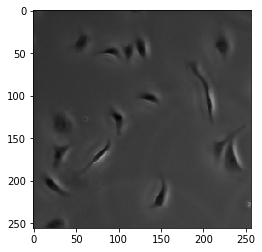

In [3]:
img = cv2.imread('/home/julienne/Documents/Segmentation_Project/Training/PHASE/PHASE000001.png', 1) 

arr = np.asarray(img)
plt.imshow(arr, cmap='gray')                 
plt.show()

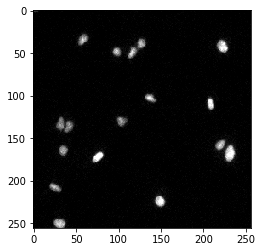

In [4]:
img = cv2.imread('/home/julienne/Documents/Segmentation_Project/Training/DAPI/DAPI000001.png', 1) 

arr = np.asarray(img)
plt.imshow(arr, cmap='gray')                 
plt.show()

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable.

In [5]:
# Example of how to display these re-sized images 
id_ = phase_train_list[0]
path = TRAIN_PATH + 'PHASE/'
img = imread(path + id_)[:,:,:3]
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#misc.imshow(img)

img -= np.mean(img, axis=(0, 1), keepdims=1)
#img = img.astype(np.int8)

print(np.mean(img))
print(np.min(img))
print(np.max(img))

# How to display images (for later):
#img = img.view(np.uint8)
#img += 128
#misc.imshow(img)

'''
Y_train = np.zeros((len(phase_train_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)
Y_train[0][:,:,0] = img[:,:,0]

new_img = Y_train[0][:,:,0]
new_img = new_img.view(np.uint8)
new_img += 128
misc.imshow(new_img)
print(np.shape(Y_train[0]))
'''


-3.7007434154171886e-16
-55.48956298828121
90.51043701171892


'\nY_train = np.zeros((len(phase_train_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)\nY_train[0][:,:,0] = img[:,:,0]\n\nnew_img = Y_train[0][:,:,0]\nnew_img = new_img.view(np.uint8)\nnew_img += 128\nmisc.imshow(new_img)\nprint(np.shape(Y_train[0]))\n'

In [6]:
# Get and resize train images 
X_train = np.zeros((len(phase_train_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.int8)
Y_train = np.zeros((len(dapi_train_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int8)

print('Getting and resizing phase train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(phase_train_list), total=len(phase_train_list)):
    path = TRAIN_PATH + 'PHASE/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img -= np.mean(img, axis=(0, 1), keepdims=1)
    X_train[n] = img
    
print('Getting and resizing DAPI train images... ')

for n, id_ in tqdm(enumerate(dapi_train_list), total=len(dapi_train_list)):
    path = TRAIN_PATH + 'DAPI/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img -= np.mean(img, axis=(0, 1), keepdims=1)
    Y_train[n][:,:,0] = img[:,:,0]
    

# Get and resize test images
X_test = np.zeros((len(phase_test_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.int8)
Y_test = np.zeros((len(dapi_test_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.int8)
    
print('Getting and resizing phase test images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(phase_test_list), total=len(phase_test_list)):
    path = TEST_PATH + 'PHASE/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img -= np.mean(img, axis=(0, 1), keepdims=1)
    X_test[n] = img
    
print('Getting and resizing DAPI test images... ')

for n, id_ in tqdm(enumerate(dapi_test_list), total=len(dapi_test_list)):
    path = TEST_PATH + 'DAPI/'
    img = imread(path + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img -= np.mean(img, axis=(0, 1), keepdims=1)
    Y_test[n][:,:,0] = img[:,:,0]

print('Done!')



Getting and resizing phase train images... 


  0%|          | 28/9830 [00:00<00:35, 274.88it/s]

Getting and resizing DAPI train images... 


100%|██████████| 9830/9830 [00:34<00:00, 288.29it/s]

Getting and resizing phase test images... 



  1%|          | 27/2458 [00:00<00:09, 266.64it/s]

Getting and resizing DAPI test images... 


100%|██████████| 2458/2458 [00:08<00:00, 280.62it/s]

Done!


Checking out a random example... 

In [7]:
def display_int8_img(img):
    img = img.view(np.uint8)
    img += 128
    misc.imshow(img)


ix = random.randint(0, len(phase_train_list))
print(ix)
display_int8_img(X_train[ix])  

print(np.max(X_train[ix]))
print(np.min(X_train[ix]))
print(np.mean(X_train[ix]))

print(phase_train_list[0])
print(dapi_train_list[0])

5001


/home/julienne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imshow` is deprecated!
`imshow` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``matplotlib.pyplot.imshow`` instead.
  after removing the cwd from sys.path.


127
-128
14.49676513671875
PHASE000001.png
DAPI000001.png


# The Machine Learning Part 

Creating the IoU metric for training: 

In [ ]:
# TODO
# Heatmap metric
# Normalize all images (mean)



# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [8]:
import keras
from keras import optimizers

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)


outputs = Conv2D(1, (1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adad = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(loss='mean_squared_error',
              optimizer=adad,
              metrics=['mse', 'acc'])
model.load_weights('no_last_model-dsbowl2018-1_OLD.h5', by_name=True)
#model.summary()

In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [10]:
# Fit model

#earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-4.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=500, 
                    callbacks=[checkpointer])

Train on 8847 samples, validate on 983 samples
Epoch 1/500
8847/8847 [==============================] - 27s 3ms/step - loss: 520.2978 - mean_squared_error: 520.2978 - acc: 0.0228 - val_loss: 273.5464 - val_mean_squared_error: 273.5464 - val_acc: 0.0308

Epoch 00001: val_loss improved from inf to 273.54640, saving model to model-dsbowl2018-4.h5
Epoch 2/500
8847/8847 [==============================] - 24s 3ms/step - loss: 519.2421 - mean_squared_error: 519.2421 - acc: 0.0227 - val_loss: 273.4087 - val_mean_squared_error: 273.4087 - val_acc: 0.0308

Epoch 00002: val_loss improved from 273.54640 to 273.40875, saving model to model-dsbowl2018-4.h5
Epoch 3/500
8847/8847 [==============================] - 24s 3ms/step - loss: 518.9549 - mean_squared_error: 518.9549 - acc: 0.0227 - val_loss: 273.4539 - val_mean_squared_error: 273.4539 - val_acc: 0.0298

Epoch 00003: val_loss did not improve from 273.40875
Epoch 4/500
8847/8847 [==============================] - 24s 3ms/step - loss: 518.7750 - 

8847/8847 [==============================] - 24s 3ms/step - loss: 517.5472 - mean_squared_error: 517.5472 - acc: 0.0228 - val_loss: 272.6173 - val_mean_squared_error: 272.6173 - val_acc: 0.0308

Epoch 00030: val_loss did not improve from 272.57021
Epoch 31/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5281 - mean_squared_error: 517.5281 - acc: 0.0228 - val_loss: 272.6666 - val_mean_squared_error: 272.6666 - val_acc: 0.0309

Epoch 00031: val_loss did not improve from 272.57021
Epoch 32/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5192 - mean_squared_error: 517.5192 - acc: 0.0228 - val_loss: 272.6031 - val_mean_squared_error: 272.6031 - val_acc: 0.0308

Epoch 00032: val_loss did not improve from 272.57021
Epoch 33/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5075 - mean_squared_error: 517.5075 - acc: 0.0228 - val_loss: 272.5684 - val_mean_squared_error: 272.5684 - val_acc: 0.0306

Epoch 00033: val_loss 


Epoch 00060: val_loss did not improve from 272.54779
Epoch 61/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4070 - mean_squared_error: 517.4070 - acc: 0.0228 - val_loss: 272.5676 - val_mean_squared_error: 272.5676 - val_acc: 0.0308

Epoch 00061: val_loss did not improve from 272.54779
Epoch 62/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4038 - mean_squared_error: 517.4038 - acc: 0.0229 - val_loss: 272.6528 - val_mean_squared_error: 272.6528 - val_acc: 0.0309

Epoch 00062: val_loss did not improve from 272.54779
Epoch 63/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4146 - mean_squared_error: 517.4146 - acc: 0.0228 - val_loss: 272.6023 - val_mean_squared_error: 272.6023 - val_acc: 0.0309

Epoch 00063: val_loss did not improve from 272.54779
Epoch 64/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4048 - mean_squared_error: 517.4048 - acc: 0.0229 - val_loss: 272.6132 - val_mea


Epoch 00091: val_loss did not improve from 272.50766
Epoch 92/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4113 - mean_squared_error: 517.4113 - acc: 0.0228 - val_loss: 272.5914 - val_mean_squared_error: 272.5914 - val_acc: 0.0308

Epoch 00092: val_loss did not improve from 272.50766
Epoch 93/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4019 - mean_squared_error: 517.4019 - acc: 0.0228 - val_loss: 272.5956 - val_mean_squared_error: 272.5956 - val_acc: 0.0309

Epoch 00093: val_loss did not improve from 272.50766
Epoch 94/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.3968 - mean_squared_error: 517.3968 - acc: 0.0229 - val_loss: 272.5665 - val_mean_squared_error: 272.5665 - val_acc: 0.0310

Epoch 00094: val_loss did not improve from 272.50766
Epoch 95/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4077 - mean_squared_error: 517.4077 - acc: 0.0228 - val_loss: 272.5454 - val_mea

8847/8847 [==============================] - 24s 3ms/step - loss: 517.4234 - mean_squared_error: 517.4234 - acc: 0.0228 - val_loss: 272.6426 - val_mean_squared_error: 272.6426 - val_acc: 0.0308

Epoch 00123: val_loss did not improve from 272.50766
Epoch 124/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4313 - mean_squared_error: 517.4313 - acc: 0.0228 - val_loss: 272.5610 - val_mean_squared_error: 272.5610 - val_acc: 0.0309

Epoch 00124: val_loss did not improve from 272.50766
Epoch 125/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4203 - mean_squared_error: 517.4203 - acc: 0.0228 - val_loss: 272.5771 - val_mean_squared_error: 272.5771 - val_acc: 0.0309

Epoch 00125: val_loss did not improve from 272.50766
Epoch 126/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4361 - mean_squared_error: 517.4361 - acc: 0.0229 - val_loss: 272.5688 - val_mean_squared_error: 272.5688 - val_acc: 0.0308

Epoch 00126: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.4614 - mean_squared_error: 517.4614 - acc: 0.0228 - val_loss: 272.7124 - val_mean_squared_error: 272.7124 - val_acc: 0.0309

Epoch 00154: val_loss did not improve from 272.50766
Epoch 155/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4584 - mean_squared_error: 517.4584 - acc: 0.0228 - val_loss: 272.6745 - val_mean_squared_error: 272.6745 - val_acc: 0.0309

Epoch 00155: val_loss did not improve from 272.50766
Epoch 156/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4513 - mean_squared_error: 517.4513 - acc: 0.0229 - val_loss: 272.6220 - val_mean_squared_error: 272.6220 - val_acc: 0.0309

Epoch 00156: val_loss did not improve from 272.50766
Epoch 157/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4436 - mean_squared_error: 517.4436 - acc: 0.0229 - val_loss: 272.6111 - val_mean_squared_error: 272.6111 - val_acc: 0.0310

Epoch 00157: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.4869 - mean_squared_error: 517.4869 - acc: 0.0228 - val_loss: 272.6211 - val_mean_squared_error: 272.6211 - val_acc: 0.0309

Epoch 00185: val_loss did not improve from 272.50766
Epoch 186/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4707 - mean_squared_error: 517.4707 - acc: 0.0228 - val_loss: 272.6338 - val_mean_squared_error: 272.6338 - val_acc: 0.0307

Epoch 00186: val_loss did not improve from 272.50766
Epoch 187/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4886 - mean_squared_error: 517.4886 - acc: 0.0228 - val_loss: 272.6852 - val_mean_squared_error: 272.6852 - val_acc: 0.0310

Epoch 00187: val_loss did not improve from 272.50766
Epoch 188/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.4887 - mean_squared_error: 517.4887 - acc: 0.0229 - val_loss: 272.7280 - val_mean_squared_error: 272.7280 - val_acc: 0.0309

Epoch 00188: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.5039 - mean_squared_error: 517.5039 - acc: 0.0228 - val_loss: 272.6065 - val_mean_squared_error: 272.6065 - val_acc: 0.0310

Epoch 00216: val_loss did not improve from 272.50766
Epoch 217/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5199 - mean_squared_error: 517.5199 - acc: 0.0228 - val_loss: 272.6691 - val_mean_squared_error: 272.6691 - val_acc: 0.0310

Epoch 00217: val_loss did not improve from 272.50766
Epoch 218/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5168 - mean_squared_error: 517.5168 - acc: 0.0228 - val_loss: 272.6058 - val_mean_squared_error: 272.6058 - val_acc: 0.0309

Epoch 00218: val_loss did not improve from 272.50766
Epoch 219/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5167 - mean_squared_error: 517.5167 - acc: 0.0228 - val_loss: 272.5716 - val_mean_squared_error: 272.5716 - val_acc: 0.0309

Epoch 00219: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.5693 - mean_squared_error: 517.5693 - acc: 0.0228 - val_loss: 272.7871 - val_mean_squared_error: 272.7871 - val_acc: 0.0310

Epoch 00247: val_loss did not improve from 272.50766
Epoch 248/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5464 - mean_squared_error: 517.5464 - acc: 0.0228 - val_loss: 272.6433 - val_mean_squared_error: 272.6433 - val_acc: 0.0308

Epoch 00248: val_loss did not improve from 272.50766
Epoch 249/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5578 - mean_squared_error: 517.5578 - acc: 0.0228 - val_loss: 272.6358 - val_mean_squared_error: 272.6358 - val_acc: 0.0308

Epoch 00249: val_loss did not improve from 272.50766
Epoch 250/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5493 - mean_squared_error: 517.5493 - acc: 0.0229 - val_loss: 272.6664 - val_mean_squared_error: 272.6664 - val_acc: 0.0310

Epoch 00250: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.5853 - mean_squared_error: 517.5853 - acc: 0.0229 - val_loss: 272.7402 - val_mean_squared_error: 272.7402 - val_acc: 0.0310

Epoch 00278: val_loss did not improve from 272.50766
Epoch 279/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6418 - mean_squared_error: 517.6418 - acc: 0.0229 - val_loss: 272.6854 - val_mean_squared_error: 272.6854 - val_acc: 0.0309

Epoch 00279: val_loss did not improve from 272.50766
Epoch 280/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6182 - mean_squared_error: 517.6182 - acc: 0.0229 - val_loss: 272.6874 - val_mean_squared_error: 272.6874 - val_acc: 0.0309

Epoch 00280: val_loss did not improve from 272.50766
Epoch 281/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6011 - mean_squared_error: 517.6011 - acc: 0.0229 - val_loss: 272.6340 - val_mean_squared_error: 272.6340 - val_acc: 0.0310

Epoch 00281: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.5786 - mean_squared_error: 517.5786 - acc: 0.0229 - val_loss: 272.6509 - val_mean_squared_error: 272.6509 - val_acc: 0.0310

Epoch 00309: val_loss did not improve from 272.50766
Epoch 310/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6077 - mean_squared_error: 517.6077 - acc: 0.0229 - val_loss: 272.6879 - val_mean_squared_error: 272.6879 - val_acc: 0.0310

Epoch 00310: val_loss did not improve from 272.50766
Epoch 311/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.5878 - mean_squared_error: 517.5877 - acc: 0.0229 - val_loss: 272.6491 - val_mean_squared_error: 272.6491 - val_acc: 0.0310

Epoch 00311: val_loss did not improve from 272.50766
Epoch 312/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6098 - mean_squared_error: 517.6099 - acc: 0.0229 - val_loss: 272.6982 - val_mean_squared_error: 272.6982 - val_acc: 0.0310

Epoch 00312: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.6541 - mean_squared_error: 517.6541 - acc: 0.0229 - val_loss: 272.6683 - val_mean_squared_error: 272.6683 - val_acc: 0.0309

Epoch 00340: val_loss did not improve from 272.50766
Epoch 341/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6376 - mean_squared_error: 517.6376 - acc: 0.0228 - val_loss: 272.7054 - val_mean_squared_error: 272.7054 - val_acc: 0.0308

Epoch 00341: val_loss did not improve from 272.50766
Epoch 342/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6341 - mean_squared_error: 517.6341 - acc: 0.0228 - val_loss: 272.7669 - val_mean_squared_error: 272.7669 - val_acc: 0.0310

Epoch 00342: val_loss did not improve from 272.50766
Epoch 343/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6491 - mean_squared_error: 517.6491 - acc: 0.0229 - val_loss: 272.6442 - val_mean_squared_error: 272.6442 - val_acc: 0.0309

Epoch 00343: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.6353 - mean_squared_error: 517.6353 - acc: 0.0229 - val_loss: 272.6707 - val_mean_squared_error: 272.6707 - val_acc: 0.0309

Epoch 00371: val_loss did not improve from 272.50766
Epoch 372/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6641 - mean_squared_error: 517.6641 - acc: 0.0229 - val_loss: 272.7653 - val_mean_squared_error: 272.7653 - val_acc: 0.0311

Epoch 00372: val_loss did not improve from 272.50766
Epoch 373/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6602 - mean_squared_error: 517.6602 - acc: 0.0229 - val_loss: 272.6760 - val_mean_squared_error: 272.6760 - val_acc: 0.0310

Epoch 00373: val_loss did not improve from 272.50766
Epoch 374/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6817 - mean_squared_error: 517.6817 - acc: 0.0229 - val_loss: 272.6746 - val_mean_squared_error: 272.6746 - val_acc: 0.0310

Epoch 00374: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.6843 - mean_squared_error: 517.6843 - acc: 0.0229 - val_loss: 272.6780 - val_mean_squared_error: 272.6780 - val_acc: 0.0309

Epoch 00402: val_loss did not improve from 272.50766
Epoch 403/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7150 - mean_squared_error: 517.7151 - acc: 0.0229 - val_loss: 272.8404 - val_mean_squared_error: 272.8404 - val_acc: 0.0311

Epoch 00403: val_loss did not improve from 272.50766
Epoch 404/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7111 - mean_squared_error: 517.7111 - acc: 0.0229 - val_loss: 272.6802 - val_mean_squared_error: 272.6802 - val_acc: 0.0310

Epoch 00404: val_loss did not improve from 272.50766
Epoch 405/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.6894 - mean_squared_error: 517.6894 - acc: 0.0229 - val_loss: 272.7167 - val_mean_squared_error: 272.7167 - val_acc: 0.0309

Epoch 00405: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.6738 - mean_squared_error: 517.6738 - acc: 0.0229 - val_loss: 272.6891 - val_mean_squared_error: 272.6891 - val_acc: 0.0310

Epoch 00433: val_loss did not improve from 272.50766
Epoch 434/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7092 - mean_squared_error: 517.7092 - acc: 0.0229 - val_loss: 272.8281 - val_mean_squared_error: 272.8281 - val_acc: 0.0311

Epoch 00434: val_loss did not improve from 272.50766
Epoch 435/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7353 - mean_squared_error: 517.7353 - acc: 0.0229 - val_loss: 273.0415 - val_mean_squared_error: 273.0415 - val_acc: 0.0312

Epoch 00435: val_loss did not improve from 272.50766
Epoch 436/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7131 - mean_squared_error: 517.7131 - acc: 0.0229 - val_loss: 272.7988 - val_mean_squared_error: 272.7988 - val_acc: 0.0311

Epoch 00436: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.7388 - mean_squared_error: 517.7388 - acc: 0.0229 - val_loss: 272.6792 - val_mean_squared_error: 272.6792 - val_acc: 0.0310

Epoch 00464: val_loss did not improve from 272.50766
Epoch 465/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7340 - mean_squared_error: 517.7340 - acc: 0.0229 - val_loss: 272.8110 - val_mean_squared_error: 272.8110 - val_acc: 0.0310

Epoch 00465: val_loss did not improve from 272.50766
Epoch 466/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7325 - mean_squared_error: 517.7325 - acc: 0.0229 - val_loss: 272.7712 - val_mean_squared_error: 272.7712 - val_acc: 0.0311

Epoch 00466: val_loss did not improve from 272.50766
Epoch 467/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7193 - mean_squared_error: 517.7193 - acc: 0.0228 - val_loss: 272.8025 - val_mean_squared_error: 272.8025 - val_acc: 0.0310

Epoch 00467: val_lo

8847/8847 [==============================] - 24s 3ms/step - loss: 517.7543 - mean_squared_error: 517.7543 - acc: 0.0229 - val_loss: 272.8303 - val_mean_squared_error: 272.8303 - val_acc: 0.0310

Epoch 00495: val_loss did not improve from 272.50766
Epoch 496/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7247 - mean_squared_error: 517.7247 - acc: 0.0229 - val_loss: 272.6908 - val_mean_squared_error: 272.6908 - val_acc: 0.0310

Epoch 00496: val_loss did not improve from 272.50766
Epoch 497/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7244 - mean_squared_error: 517.7244 - acc: 0.0229 - val_loss: 272.8917 - val_mean_squared_error: 272.8917 - val_acc: 0.0311

Epoch 00497: val_loss did not improve from 272.50766
Epoch 498/500
8847/8847 [==============================] - 24s 3ms/step - loss: 517.7357 - mean_squared_error: 517.7357 - acc: 0.0229 - val_loss: 272.7576 - val_mean_squared_error: 272.7576 - val_acc: 0.0310

Epoch 00498: val_lo

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [11]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-4.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)



2458/2458 [==============================] - 2s 818us/step


(128, 128)
(128, 128)


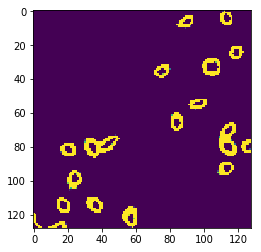

(128, 128)
(128, 128)


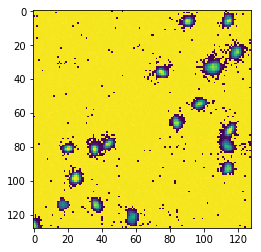

511.0
513.0
-128
127
511.1168
104.65972900390625
[[511. 511. 511. 511. 511.]
 [511. 511. 511. 511. 511.]
 [511. 511. 511. 511. 511.]
 [511. 511. 511. 511. 511.]
 [511. 511. 511. 511. 511.]]


In [37]:
ix = 2

#ix = random.randint(0, len(phase_train_list))
#print(ix)

def display_int8_img_2(img):
    print(np.shape(img))
    #img = img.view(np.uint8)
    #print(np.shape(img))
    img += 128
    print(np.shape(img))
    plt.imshow(img)
    plt.show()

display_int8_img_2(preds_test[ix][:,:,0])  
display_int8_img_2(Y_test[ix][:,:,0]) 

print(np.min(preds_test[ix][:,:,0]))
print(np.max(preds_test[ix][:,:,0]))
print(np.min(Y_test[ix][:,:,0]))
print(np.max(Y_test[ix][:,:,0]))

print(np.mean(preds_test[ix][:,:,0]))
print(np.mean(Y_test[ix][:,:,0]))

print(preds_test[ix][:5,:5,0])

In [ ]:
# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
#preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples


The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [ ]:
# Perform a sanity check on some random validation samples
